In [2]:
import numpy as np
import pyLDAvis.gensim
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

from timeout import timeout

import comparison_funcs as cf

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
def prep_corpus(fname):
    "reads in file, makes a gensim-usable corpus out of it"

    with open(fname, 'r') as f:
        docs_full = f.readlines()

    docs = [x.split('\t')[1].split() for x in docs_full]
    for doc in docs:
        while '<NUMBER>' in doc:
            doc.remove('<NUMBER>')
        while 'patient' in doc:
            doc.remove('patient')
        while 'cell' in doc:
            doc.remove('cell')

    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return corpus, dictionary, docs


def prep_corpus_csv(fname):
    "reads in file, makes a gensim-usable corpus out of it"

    d = pd.read_csv(fname)
        
    docs = []
    for i in range(len(d.index)):
        docs.append(d.iloc[i,2].split())
    
    for doc in docs:
        while '<NUMBER>' in doc:
            doc.remove('<NUMBER>')
        while 'patient' in doc:
            doc.remove('patient')
        while 'cell' in doc:
            doc.remove('cell')

    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return corpus, dictionary, docs


In [4]:
corp, dictionary, docs = prep_corpus_csv('sampledata.csv')
corp2, dictionary2, docs2 = prep_corpus('pubmed_subset_13.tsv')


In [5]:
@timeout(30)
def make_lda_model(k, corp, dictionary, random_state=1, iterations=1, umass=[], v=[], npmi = [], uci = [], times= []):
        start = time.time()
        lda_model = LdaModel(corpus = corp, id2word = dictionary, iterations = iterations, num_topics = k, random_state=random_state)
        cm1 = CoherenceModel(model = lda_model, corpus = corp, dictionary = dictionary, coherence = 'u_mass')
        cm2 = CoherenceModel(model = lda_model, texts = docs, dictionary = dictionary, coherence = 'c_v')
        cm3 = CoherenceModel(model = lda_model, texts = docs, dictionary = dictionary, coherence = 'c_npmi')
        cm4 = CoherenceModel(model = lda_model, texts = docs, dictionary = dictionary, coherence = 'c_uci')
        with np.errstate(invalid='ignore'):
            v_cm2 = cm2.get_coherence()
            
        umass.append(cm1.get_coherence())
        v.append(v_cm2)
        npmi.append(cm3.get_coherence())
        uci.append(cm4.get_coherence())

        end = time.time()
        times.append(end - start)
        
        return umass, v, npmi, uci, times





def loop_through_topics(k, corp, dictionary, random_state=1, iterations=1):
    umass = []
    v = []
    npmi = []
    uci = []
    times = []

    for i in k:
        umass, v, npmi, uci, times = make_lda_model(i, corp, dictionary, random_state, iterations, umass, v, npmi, uci, times)
        print('Finished model with ' + str(i) + ' topics. Time: ' + str(times[-1]))
    
    return umass, v, npmi, uci, times


In [6]:
k = list(range(10,22,2))
#k.remove(46)
#k.remove(12)
#no idea why this is happening

umass, v, npmi, uci, times = loop_through_topics(k, corp, dictionary, 1,1)

Finished model with 10 topics. Time: 4.385828256607056
Finished model with 12 topics. Time: 4.529783248901367
Finished model with 14 topics. Time: 4.813238620758057
Finished model with 16 topics. Time: 5.045055866241455
Finished model with 18 topics. Time: 5.336339235305786
Finished model with 20 topics. Time: 5.463424921035767


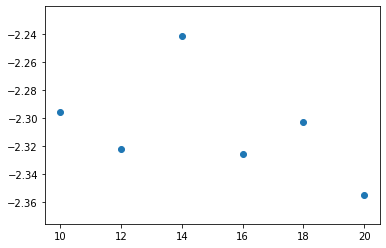

In [7]:
plt.scatter(k, umass)

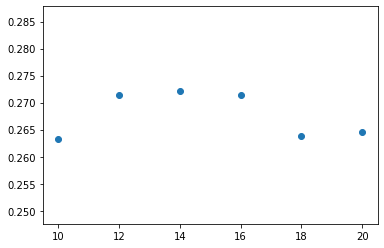

In [8]:
plt.scatter(k, v)


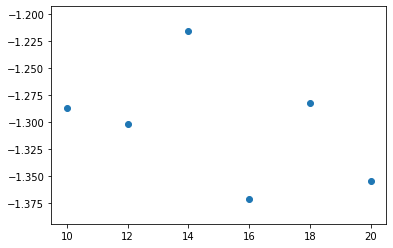

In [9]:
plt.scatter(k, uci)

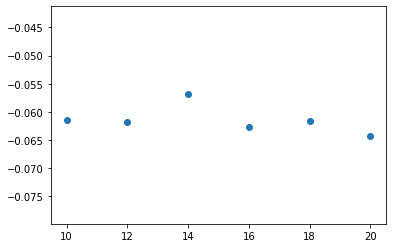

In [10]:
plt.scatter(k, npmi)

In [ ]:

lda_model = LdaModel(corpus = corp, id2word = dictionary, iterations = 1, num_topics = 7, random_state=1)

cm1 = CoherenceModel(model = lda_model, corpus = corp, dictionary = dictionary, coherence = 'u_mass')
cm2 = CoherenceModel(model = lda_model, texts = docs[-390], dictionary = dictionary, coherence = 'c_v')
cm3 = CoherenceModel(model = lda_model, texts = docs[-390], dictionary = dictionary, coherence = 'c_npmi')
cm4 = CoherenceModel(model = lda_model, texts = docs[-390], dictionary = dictionary, coherence = 'c_uci')

## To Do:

- Be able to manually identify a perplexity measure and store it, along with the params for one model
- Run the second model, searching for that perplexity value
- Compare the two models using jaccard / diff

In [ ]:
for i in range(len(docs)):
    if len(docs[i]) < 10:
        print(i)

In [ ]:
docs[390]

In [ ]:
target_perplex = -2.1

In [ ]:
k = list(range(50,100,2))
k.remove(66)
#k.remove(12)
#no idea why this is happening

rs = 1

um, cv, times = loop_through_topics(k, corp2, dictionary2, 1,rs)

outdf = pd.DataFrame(list(zip(um, cv, times)))
outdf.to_csv('tm_stats' + str(rs) + '.csv')

In [ ]:
plt.scatter(k, um)

In [ ]:
rs = 1
outdf = pd.DataFrame(list(zip(um, cv, times)))
outdf.to_csv('tm_stats' + str(rs) + '.csv')

In [ ]:
m1 = LdaModel(corpus = corp2, id2word = dictionary2, iterations = 10, num_topics = 50, random_state=1)
m2 = LdaModel(corpus = corp2, id2word = dictionary2, iterations = 10, num_topics = 50, random_state=2)

In [ ]:
d, a = m1.diff(m2, diagonal=False)

In [ ]:
df = pd.DataFrame(d)
df.head()

In [ ]:
mins = df.min(axis=1)

In [ ]:
mins